# Search for SN-like light curves in ZTF alerts

We will use lsdb package to load a HATS catalog with [ZTF](https://www.ztf.caltech.edu) alerts.
The dataset contains all alerts sent from the beginning of the survey from 2018-05-04 to 2023-09-13 corresponding to objects having at least 20 detections.

The dataset is provided by the [ALeRCE](https://alerce.science) broker team.

The goal is to find supernova (SN) candidates in this dataset using the goodness of the Bazin ([Bazin+2009](https://doi.org/10.1051/0004-6361/200911847)) function fit, a simple parametric model for SN light curves.

The pipeline will be as follows:

1. Load the dataset with LSDB
2. Convert it to a nested format with `nested-dask` package
3. Fit Bazin function and extract some other light-curve features with `light-curve` package
4. Filter data and plot few light curves

### Install and import required packages

We need LSDB for data loading and analysis (includes [dask](https://dask.org), [nested-pandas](https://nested-pandas.readthedocs.org) and [nested-dask](https://nested-dask.readthedocs.org)) and [light-curve](https://github.com/light-curve/light-curve-python) package for feature extraction.

In [1]:
%pip install -q lsdb
# This --only-binary flag is required to avoid installation errors on some systems
%pip install -q --only-binary=light-curve light-curve

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import light_curve as licu  # light-curve feature extraction library
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Array operations
from dask.distributed import Client  # Create multi-processing cluster and connect to it
from lsdb import read_hats  # LSDB entry-point, load HATS catalog
from matplotlib.ticker import MaxNLocator  # Fix ticks on plots

### Helper function for light-curve plotting

The function accepts a pandas data frame and plots a light curve.

In [3]:
def plot_lc(lc, nondet, title=None, rband_model=None):
    """Plot light curve with non-detections."""
    for fid, band in zip([1, 2], "gr"):
        idx = lc["lc_fid"] == fid
        plt.scatter(
            lc["lc_mjd"][idx], lc["lc_magpsf"][idx], label=f"{band} detection", color=band, marker="x", s=70
        )
        plt.errorbar(
            lc["lc_mjd"][idx], lc["lc_magpsf"][idx], lc["lc_sigmapsf"][idx], color=band, ls="", capsize=5
        )

        idx = nondet["nondet_fid"] == fid
        plt.scatter(
            nondet["nondet_mjd"][idx],
            nondet["nondet_diffmaglim"][idx],
            marker="v",
            color=band,
            alpha=0.25,
            s=70,
            label=f"{band} non-detection",
        )

    if rband_model is not None:
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()

        r_times = np.linspace(xmin, xmax, 1000)
        r_mags = rband_model(r_times)
        plt.plot(r_times, r_mags, color="k", linestyle="-", label="r-band Bazin fit")

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    plt.legend(fontsize=14)
    plt.title(title, fontsize=18)
    plt.xlabel("MJD", fontsize=18)
    plt.ylabel("Magnitude", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=6))
    plt.gca().invert_yaxis()
    plt.grid(True)

### Load catalog structure and "nest" columns

Here we load the catalog structure and transform list-columns to a compact representation.
These transformed columns are "nested data frames", so each item could be represented by a small pandas dataframe.
We are going to have three nested columns:

1. "lc", for light curves, each point corresponding to some alert (detection)
2. "nondet", for non-detections (upper limits)
3. "ref", for ZTF reference objects associated with alerts

Here we have not downloaded any data yet, all data access and analysis happens only after `.compute()` is called.

Here we display two versions of the catalog: the first one is the raw catalog with nested lists, and the second one is the catalog with nested columns.

In [4]:
ZTF_ALERTS = "https://data.lsdb.io/hats/alerce/"

# Load catalog with nested lists
raw_catalog = read_hats(
    ZTF_ALERTS,
)
display(raw_catalog)

# Pack all list-columns into single column
catalog_with_lc = raw_catalog.nest_lists(
    base_columns=[col for col in raw_catalog.columns if not col.startswith("lc_")],
    name="lc",
)

# Pack non-detections
catalog_with_nondet = catalog_with_lc.nest_lists(
    base_columns=[col for col in catalog_with_lc.columns if not col.startswith("nondet_")],
    name="nondet",
)

# Pack ZTF references
catalog = catalog_with_nondet.nest_lists(
    base_columns=[col for col in catalog_with_nondet.columns if not col.startswith("ref_")],
    name="ref",
)

catalog

,oid,mean_ra,mean_dec,lc_ra,lc_dec,lc_candid,lc_mjd,lc_fid,lc_pid,lc_diffmaglim,lc_isdiffpos,lc_nid,lc_magpsf,lc_sigmapsf,lc_magap,lc_sigmagap,lc_distnr,lc_rb,lc_rbversion,lc_drb,lc_drbversion,lc_magapbig,lc_sigmagapbig,lc_rfid,lc_magpsf_corr,lc_sigmapsf_corr,lc_sigmapsf_corr_ext,lc_corrected,lc_dubious,lc_parent_candid,lc_has_stamp,lc_step_id_corr,nondet_mjd,nondet_fid,nondet_diffmaglim,ref_rfid,ref_candid,ref_fid,ref_rcid,ref_field,ref_magnr,ref_sigmagnr,ref_chinr,ref_sharpnr,ref_ranr,ref_decnr,ref_mjdstartref,ref_mjdendref,ref_nframesref,Norder,Dir,Npix
npartitions=113,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",string[pyarrow],double[pyarrow],double[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: bool>[pyarrow],list<element: bool>[pyarrow],list<element: double>[pyarrow],list<element: bool>[pyarrow],list<element: string>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: int64>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: double>[pyarrow],list<element: int64>[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow]
"Order: 2, Pixel: 4",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


,oid,mean_ra,mean_dec,Norder,Dir,Npix,lc,nondet,ref
npartitions=113,,,,,,,,,
"Order: 1, Pixel: 0",string[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],"nested<lc_ra: [double], lc_dec: [double], lc_c...","nested<nondet_mjd: [double], nondet_fid: [int6...","nested<ref_rfid: [int64], ref_candid: [int64],..."
"Order: 2, Pixel: 4",...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...


### Plot example light curves

It is time to run our first `.compute()`!
Here we select the first catalog partition (e.g. a single catalog file), load it and plot first five light curves from this file.

Note how we use nested "lc" column here: each value is represented by a pandas light curve, which we use for plotting.

In [5]:
# "Compute" the first HATS partition and plot few light curves

# Single partition requires a single worker
with Client(n_workers=1) as client:
    display(client)
    ndf = catalog.partitions[0].compute()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49903,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:49908,Total threads: 12
Dashboard: http://127.0.0.1:49909/status,Memory: 32.00 GiB
Nanny: tcp://127.0.0.1:49906,


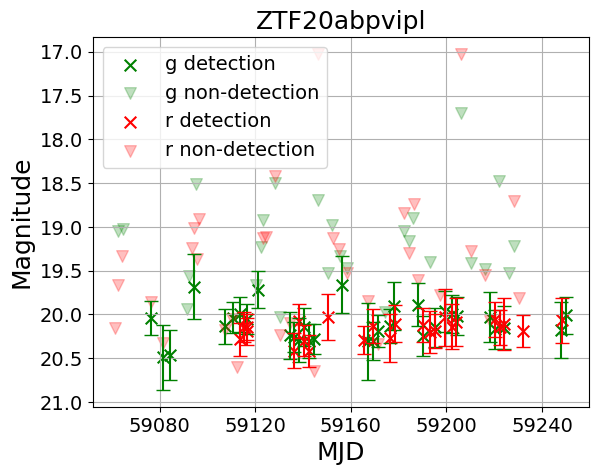

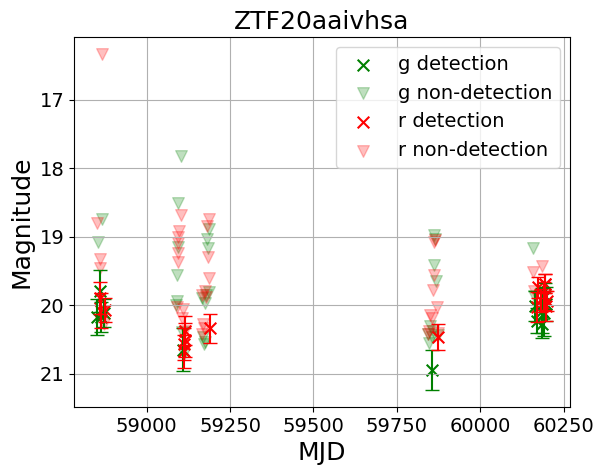

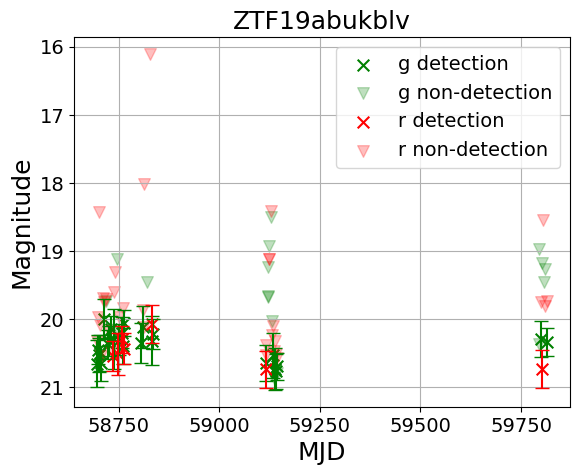

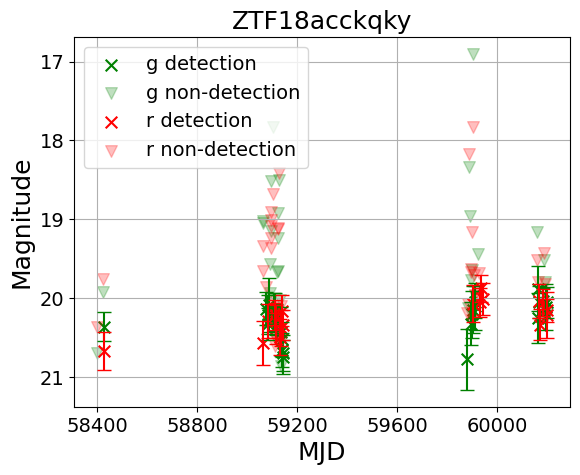

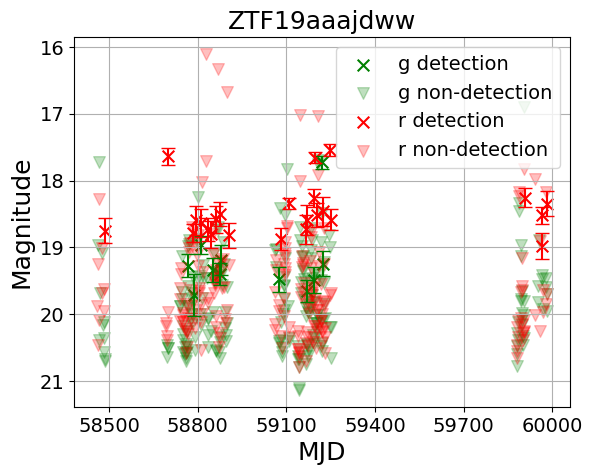

In [6]:
for i in range(5):
    lc = ndf["lc"].iloc[i]
    oid = ndf["oid"].iloc[i]
    nondet = ndf["nondet"].iloc[i]
    plt.figure()
    plot_lc(lc, nondet, title=str(oid))

### Extract features and filter

Here we use the [light-curve](https://github.com/light-curve/light-curve-python) package to fit each r-band light-curve with Bazin function (Bazin+2009).

<div>
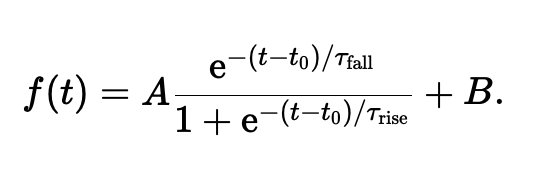
</div>

We also extract number of observations and reduced χ² of the fit with constant function to filter objects with low variability.

<div>
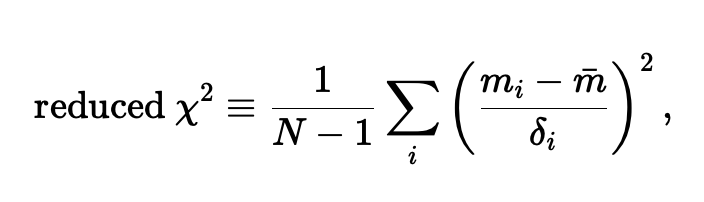
</div>

Here we use the `.reduce()` method of the `Catalog` object to apply the feature extraction function to each row of the catalog.
It is very similar to the `pandas.DataFrame.apply()` method but it works more efficiently and conveniently with nested data.
See [`nested-pandas` documentation](https://nested-pandas.readthedocs.io/en/latest/gettingstarted/quickstart.html#Reduce-Function) for more details.

In [7]:
# Initialize feature extractor to be used in extract_features() function
bazin_fit = licu.BazinFit(algorithm="ceres", ceres_niter=20, ceres_loss_reg=3)
feature_extractor = licu.Extractor(
    bazin_fit,
    licu.ObservationCount(),
    licu.ReducedChi2(),
)


def extract_features(band, t, m, sigma, oid):
    # Select r-band only and remove observations with NaN errors
    valid_r = (band == 2) & np.isfinite(sigma)
    t, m, sigma = t[valid_r], m[valid_r], sigma[valid_r]

    # Sort time and remove duplicated, required by light-curve package
    _, idx = np.unique(t, return_index=True)
    t, m, sigma = t[idx], m[idx], sigma[idx]

    # Convert magnitude to fluxes
    flux = 10 ** (-0.4 * (m - 8.9))
    flux_err = 0.4 * np.log(10) * sigma * flux

    # Output NaN feature value if we cannot compute it,
    # e.g. we don't have enough r-band observations
    values = feature_extractor(t, flux, flux_err, fill_value=np.nan)
    return dict(zip(feature_extractor.names, values))


# Extract features and filter objects by them
catalog_with_features = catalog.reduce(
    extract_features,  # function
    "lc.lc_fid",
    "lc.lc_mjd",
    "lc.lc_magpsf",
    "lc.lc_sigmapsf",
    "oid",  # columns to use
    meta=dict.fromkeys(feature_extractor.names, float),  # Dask meta
    append_columns=True,  # Add the result feature columns to the catalog
)

# Filter features to get nice light-curves
sn_candidates = catalog_with_features.query(
    "bazin_fit_reduced_chi2 > 0.8 and bazin_fit_reduced_chi2 < 3.0"
    " and bazin_fit_rise_time > 3 and bazin_fit_rise_time < 10"
    " and bazin_fit_fall_time < 30 and bazin_fit_fall_time > 10"
    " and observation_count >= 10"
    " and chi2 > 5.0"
)

sn_candidates

,oid,mean_ra,mean_dec,Norder,Dir,Npix,lc,nondet,ref,bazin_fit_amplitude,bazin_fit_baseline,bazin_fit_reference_time,bazin_fit_rise_time,bazin_fit_fall_time,bazin_fit_reduced_chi2,observation_count,chi2
npartitions=113,,,,,,,,,,,,,,,,,
"Order: 1, Pixel: 0",string[pyarrow],double[pyarrow],double[pyarrow],int8[pyarrow],int64[pyarrow],int64[pyarrow],"nested<lc_ra: [double], lc_dec: [double], lc_c...","nested<nondet_mjd: [double], nondet_fid: [int6...","nested<ref_rfid: [int64], ref_candid: [int64],...",float64,float64,float64,float64,float64,float64,float64,float64
"Order: 2, Pixel: 4",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 10",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 0, Pixel: 11",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Run analysis

Let's run our analysis over the whole catalog and output the result to a `nested-pandas` data-frame object. We run the analysis in parallel using Dask.
See the [Dask cluster configuration](https://docs.lsdb.io/en/latest/tutorials/dask-cluster-tips.html) documentation page for tips on Dask `Client` initialization.

The code will download ~21GB of data.
Check your Internet connection speed and give it some time.
You can tracj the progress with the Dask dashboard.
(You can also select a single partition as we did before, just replace `.compute()` with `.partitions[0].compute()`.)

In [8]:
%%time

with Client(n_workers=6, memory_limit="10GB", threads_per_worker=2) as client:
    display(client)
    ndf = sn_candidates.compute()

ndf

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 55.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49939,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 55.88 GiB
Comm: tcp://127.0.0.1:49956,Total threads: 2
Dashboard: http://127.0.0.1:49965/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:49942,


CPU times: user 1min 7s, sys: 20.8 s, total: 1min 28s
Wall time: 20min 37s


oid     mean_ra  mean_dec  Norder  Dir  Npix  \
_healpix_29                                                                  
2405857242818793     ZTF20abwzqzo   41.513817  3.329906       1    0     0   
3203066719741431     ZTF22abmxzxm    42.60675  5.793783       1    0     0   
...                           ...         ...       ...     ...  ...   ...   
3454646200271876674  ZTF22aamgkdw  317.380631 -7.029933       0    0    11   
3455632615629906897  ZTF22aaudftc  318.113332 -5.166991       0    0    11   

                                                                    lc  \
_healpix_29                                                              
2405857242818793     [{lc_ra: 41.513804, lc_dec: 3.329934, lc_candi...   
3203066719741431     [{lc_ra: 42.606741, lc_dec: 5.793787, lc_candi...   
...                                                                ...   
3454646200271876674  [{lc_ra: 317.380617, lc_dec: -7.029944, lc_can...   
3455632615629906897  [{lc_ra: 318.113338, lc_dec: -5.166983, lc_can...   

                                                                nondet  \
_healpix_29                                                              
2405857242818793     [{nondet_mjd: 59062.398843, nondet_fid: 1, non...   
3203066719741431     [{nondet_mjd: 59840.406748, nondet_fid: 1, non...   
...                                                                ...   
3454646200271876674  [{nondet_mjd: 59711.434109, nondet_fid: 1, non...   
3455632615629906897  [{nondet_mjd: 59753.422766, nondet_fid: 1, non...   

                                                                   ref  \
_healpix_29                                                              
2405857242818793     [{ref_rfid: 452120223, ref_candid: 13334472123...   
3203066719741431     [{ref_rfid: 452120233, ref_candid: 21113824933...   
...                                                                ...   
3454646200271876674  [{ref_rfid: 389120155, ref_candid: 19773975655...   
3455632615629906897  [{ref_rfid: 441120209, ref_candid: 20254388809...   

                     bazin_fit_amplitude  bazin_fit_baseline  \
_healpix_29                                                    
2405857242818793                0.000408            0.000030   
3203066719741431                0.000363            0.000032   
...                                  ...                 ...   
3454646200271876674             0.000159            0.000009   
3455632615629906897             0.000378            0.000006   

                     bazin_fit_reference_time  bazin_fit_rise_time  \
_healpix_29                                                          
2405857242818793                 59100.573583             3.111346   
3203066719741431                 59870.560379             3.061167   
...                                       ...                  ...   
3454646200271876674              59734.389038             3.042295   
3455632615629906897              59784.483389             4.827309   

                     bazin_fit_fall_time  bazin_fit_reduced_chi2  \
_healpix_29                                                        
2405857242818793               11.490058                0.879535   
3203066719741431               20.848320                1.679472   
...                                  ...                     ...   
3454646200271876674            21.088878                1.352102   
3455632615629906897            23.854929                1.386482   

                     observation_count       chi2  
_healpix_29                                        
2405857242818793                  28.0  56.120445  
3203066719741431                  13.0  36.492215  
...                                ...        ...  
3454646200271876674               13.0  17.269565  
3455632615629906897               15.0  28.707617  

[796 rows x 17 columns]

### Plot SN candidate light curves

Let's plot light curves of our objects and compare them to what we had before.
They look like really nice SN candidates, go check them with the ALeRCE online viewer!

https://alerce.online/object/ZTF19aaajdww
https://alerce.online/object/ZTF19aaajdww
https://alerce.online/object/ZTF19aaajdww
https://alerce.online/object/ZTF19aaajdww
https://alerce.online/object/ZTF19aaajdww


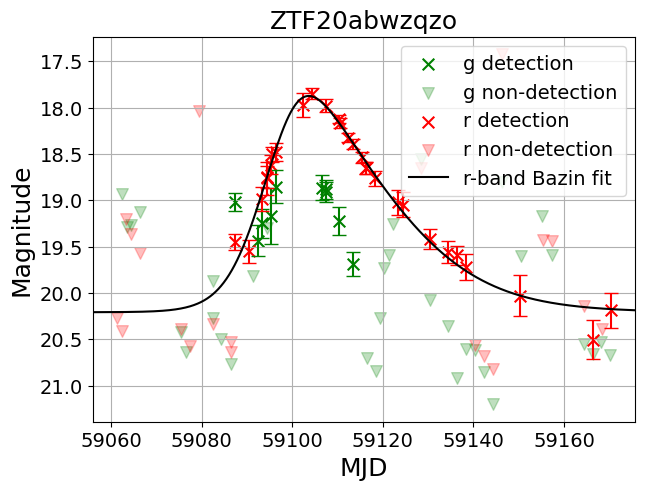

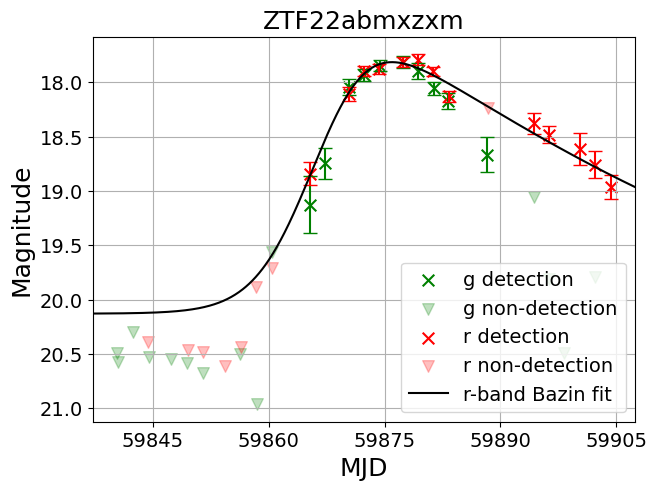

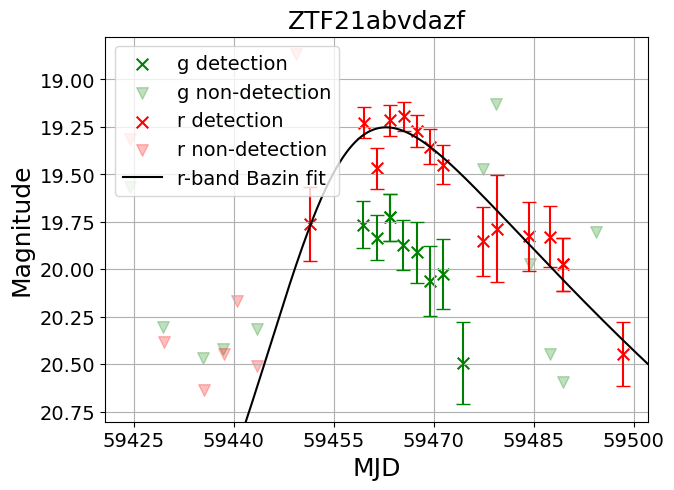

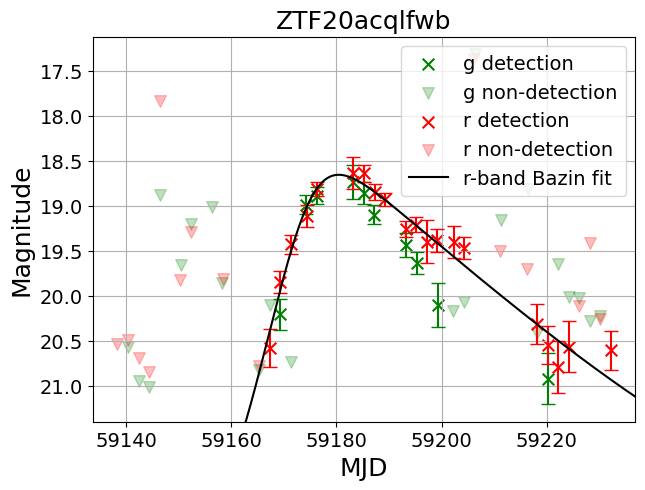

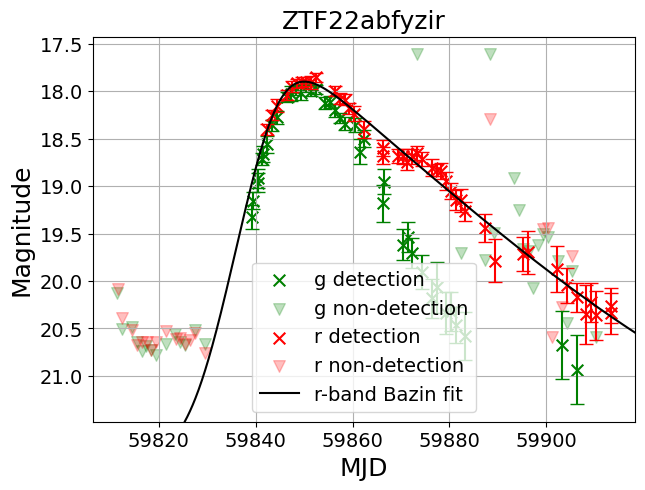

In [9]:
head = ndf.head(5)

for _healpix29, row in head.iterrows():
    plt.figure(figsize=(7, 5))

    def model(time):
        time = np.asarray(time)
        params = np.asarray(row[bazin_fit.names], dtype=time.dtype)
        flux = bazin_fit.model(time, params)
        mag = 8.9 - 2.5 * np.log10(flux)
        return mag

    plot_lc(row["lc"], row["nondet"], title=row["oid"], rband_model=model)
    print(f"https://alerce.online/object/{oid}")